# Building CNN Algorithm on American Sign Language Dataset

![image](https://miro.medium.com/max/696/0*vmgQDtKZthpE9Fel)

<hr>

# Table of Contents
1. [Description About Notebook](#description)
2. [Importing Libraries and Tensorflow](#importing)
3. [Data Preprocessing](#preprocess)
    - [Countplot of Labels](#countplot)
    - [First Eight Samples](#firsteight)
4. [Building Model](#model)
    - [Data Augmentation](#augmentation)
    - [Callbacks](#callbacks)
    - [Building CNN Model](#cnn)
    - [Plot of Progress](#progress)
    - [Confusion Matrix for Checking Results](#confusion)
5. [Testing](#testing)   

# Description About Notebook<a class="anchor" id="description"></a>



As we know, there are many health issues that affect human interaction, and deafness is one of them. We are getting more solutions while Artificial Intelligence concept is progressing. In this notebook, we are going to build a Deep Learning model by using CNN Algorithm as being a part of the process of solving communication problems that deafness causes.

### Note 1: This dataset has 25 labels instead of 26 because 'J' and 'Z' letters are need to hand gestures for understanding but maker of the dataset may have thought that the 'Z' letter has a specific looking and can be stored, because of that we still have 'Z' letter and the other letters except 'J'.

#### Note 2: This dataset has incorrect labeling for a few labels, it rarely gives wrong answers for image but we can see it is correct when we compare how it labeled below.

<hr>

# Importing Libraries and Tensorflow<a class="anchor" id="importing"></a>

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra,math functions
import tensorflow as tf # tensorflow
import random # for seed value
import os # for folder functions
import string # for making alphabet labels as string
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
for dirname, _, filenames in os.walk('/kaggle/input'): # default
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [43]:
seed=42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# We are using random seeds for controlling randomness.

<hr>

# Data Preprocessing<a class="anchor" id="preprocess"></a>

In [44]:
train_data=pd.read_csv("/workspaces/BongoCat_Test/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_data=pd.read_csv("/workspaces/BongoCat_Test/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
print("Shape of train_data: ",train_data.shape,"Shape of test_data: ",test_data.shape)

Shape of train_data:  (27455, 785) Shape of test_data:  (7172, 785)


In [45]:
strlabels=list(string.ascii_uppercase) # Appending alphabet to a list.
strlabels.remove("J") # Removing J letter because of the hand gesture problem.
print(strlabels) # Making a new list that contains letters for each indices.

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [46]:
train_labels=train_data["label"]
train_images=train_data.drop("label",axis=1).values # Dropping labels axis=1 > all column (axis=0 is all row)
test_labels=test_data["label"]
test_images=test_data.drop("label",axis=1).values # Dropping Labels axis=1 > all column (axis=0 is all row)
                                               
train_images=train_images/255.0 # We are scaling our pixels between 0 and 1 for the sake of computing performance.
test_images=test_images/255.0

train_images=train_images.reshape(-1,28,28,1) # Reshaping for making images ready to go.
test_images=test_images.reshape(-1,28,28,1)
print(train_images.shape) # We have 27.455 images as 28x28x1 (2D Image with one channel)

(27455, 28, 28, 1)


## Countplot of Labels<a class="anchor" id="countplot"></a>

[Text(0, 0.5, 'Test Images'), Text(0.5, 0, 'Test Labels')]

<Figure size 1500x500 with 0 Axes>

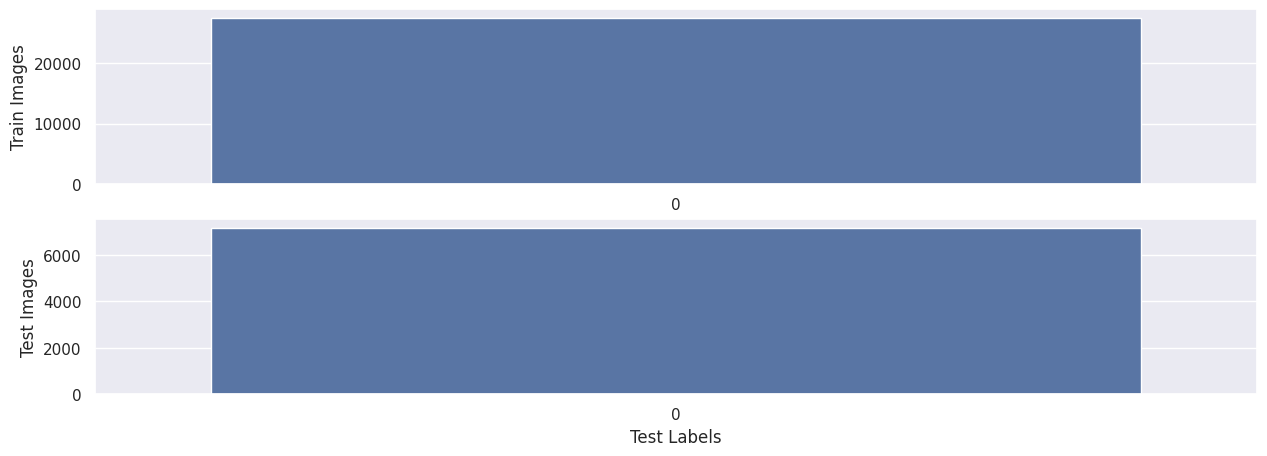

In [47]:
plt.figure() # Matplotlib for visualization.
plt.tight_layout() # Wide space for images.
fig,ax=plt.subplots(2,1) # Making space for 2 rows and 4 images for each row.
sns.set(rc={'figure.figsize':(15,5)}) # Size of images.
sns.countplot(train_labels,ax=ax[0])
ax[0].set(ylabel="Train Images", xlabel = "Train Labels") # Setting labels.
sns.countplot(test_labels,ax=ax[1])
ax[1].set(ylabel="Test Images", xlabel = "Test Labels") # Setting labels.

## First 8 Samples<a class="anchor" id="firsteight"></a>

<Figure size 1500x500 with 0 Axes>

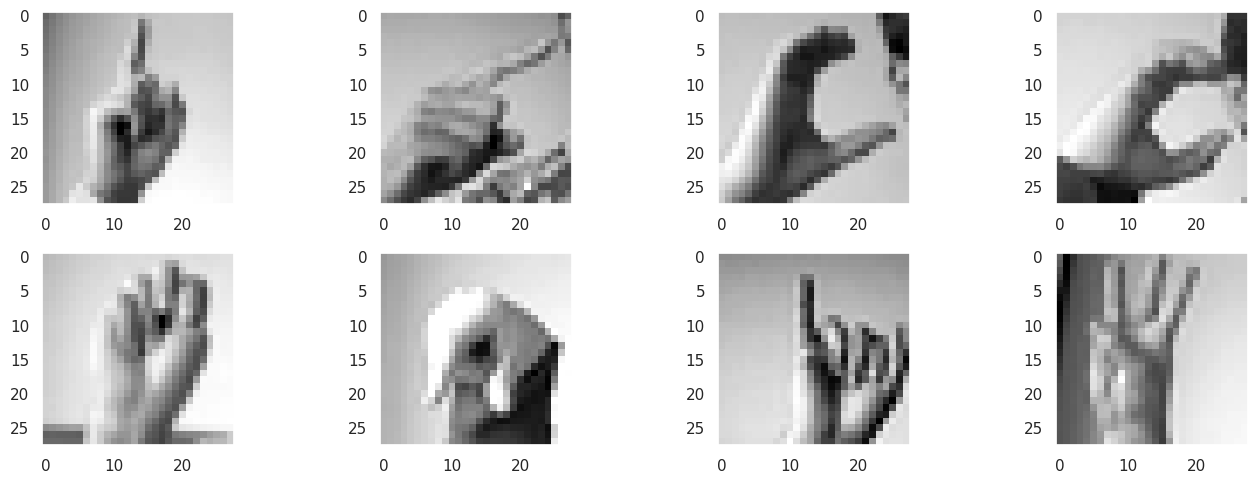

In [48]:
plt.figure() # Matplotlib for visualization.
f, graph = plt.subplots(2,4) # Making space for 2 rows and 4 images for each row.
f.set_size_inches(14, 5) # Size of images.
z=0
for i in range(2): # i for rows
    for k in range(4): # k for columns
        graph[i][k].imshow(train_images[z].reshape(28,28),cmap="gray") # Showing each train image.
        graph[i][k].grid(False) # Removing grids for each train image.
        z+=1
plt.tight_layout() # Wide space for images.
plt.show()

<hr>

# Building Model<a class="anchor" id="model"></a>

## Data Augmentation<a class="anchor" id="augmentation"></a>

In [49]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
generator.fit(train_images)
# We use ImageDataGenerator for changing images randomly and train our model better.

## Callbacks<a class="anchor" id="callbacks"></a>

In [50]:
acc_treshold = 1.0 # Accuracy treshold.
class myCallback(tf.keras.callbacks.Callback):
    epc=0
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= acc_treshold-0.005 and logs.get('val_acc') >= acc_treshold):
            print("\nReached %2.2f%% accuracy !" %(logs.get('val_acc')*100)) # Printing accuracy as percentage.
            self.model.stop_training = True
            self.epc=epoch+1
callbacks = myCallback()
# We are using callbacks because we want to shut our training process down when it learns 100%.

## Building CNN Model<a class="anchor" id="cnn"></a>

In [51]:
model=tf.keras.Sequential([ # Using tf.keras for build our sequential.
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2), # Dropping random 2% data out for learning variety.
    
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss="sparse_categorical_crossentropy",metrics=["acc"])
model.summary() # Summary of our model.
epochs=80
history=model.fit(generator.flow(train_images,train_labels,batch_size=128),epochs=epochs,callbacks=[callbacks],validation_data=(test_images,test_labels),verbose=1)
# generator.flow() for applying data augmentation.
test_loss,test_acc=model.evaluate(test_images,test_labels)
print("test acc:",test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)      

2023-06-02 17:10:34.755182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


215/215 [==============================] - 28s 127ms/step - loss: 2.5399 - acc: 0.2485 - val_loss: 3.3262 - val_acc: 0.0418
Epoch 2/80
215/215 [==============================] - 27s 126ms/step - loss: 1.4048 - acc: 0.5452 - val_loss: 2.6223 - val_acc: 0.1725
Epoch 3/80
215/215 [==============================] - 28s 129ms/step - loss: 0.9211 - acc: 0.6937 - val_loss: 0.7687 - val_acc: 0.7628
Epoch 4/80
215/215 [==============================] - 27s 125ms/step - loss: 0.6897 - acc: 0.7667 - val_loss: 0.8103 - val_acc: 0.7058
Epoch 5/80
215/215 [==============================] - 27s 126ms/step - loss: 0.5413 - acc: 0.8184 - val_loss: 0.3778 - val_acc: 0.8645
Epoch 6/80
215/215 [==============================] - 27s 126ms/step - loss: 0.4353 - acc: 0.8540 - val_loss: 0.2678 - val_acc: 0.9038
Epoch 7/80
215/215 [==============================] - 27s 125ms/step - loss: 0.3673 - acc: 0.8785 - val_loss: 0.3457 - val_acc: 0.8756
Epoch 8/80
215/215 [==============================] - 27s 124ms/st

In [57]:
prediction=model.predict(test_images) # Making predictions of test images with our model.


225/225 [==============================] - 1s 6ms/step


## Plot of Progress<a class="anchor" id="progress"></a>

<Figure size 1500x500 with 0 Axes>

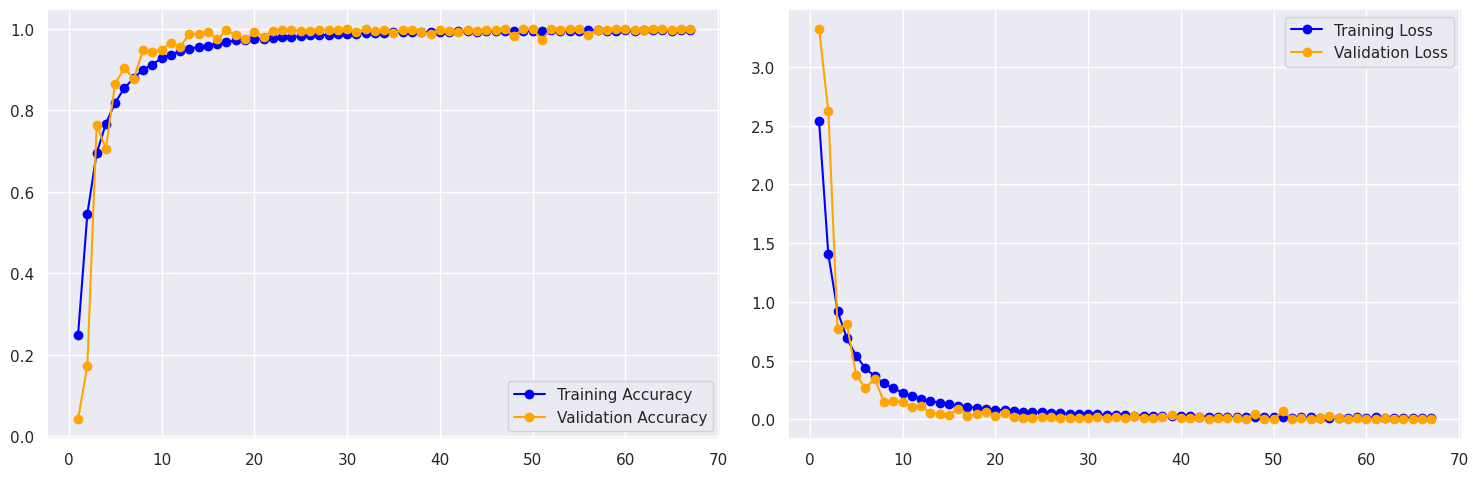

In [58]:
epoch_range=range(1,callbacks.epc+1 if callbacks.epc != 0 else epochs) # Epoch range for plotting our x-axis.
plt.figure() # Matplotlib for visualization.
f, ax = plt.subplots(1,2) # Making space for 2 rows and 4 images for each row.
fig.set_size_inches(30, 5) # Size of images.
plt.tight_layout() # Wide space for images.
ax[0].plot(epoch_range,history.history["acc"],color="blue",marker="o")
ax[0].plot(epoch_range,history.history["val_acc"],color="orange",marker="o")
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax[1].plot(epoch_range,np.array(history.history["loss"]),color="blue",marker="o")
ax[1].plot(epoch_range,np.array(history.history["val_loss"]),color="orange",marker="o")
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [59]:
predictions=[]
test_labels_string=[]
for i in range(0,test_labels.size):
    predictions.append(strlabels[np.argmax(prediction[i])]) # np.argmax() for taking highest value among the others.
    test_labels_string.append(strlabels[test_labels[i]])
# Converting predictions to letters.

## Confusion Matrix for Checking Results<a class="anchor" id="confusion"></a>

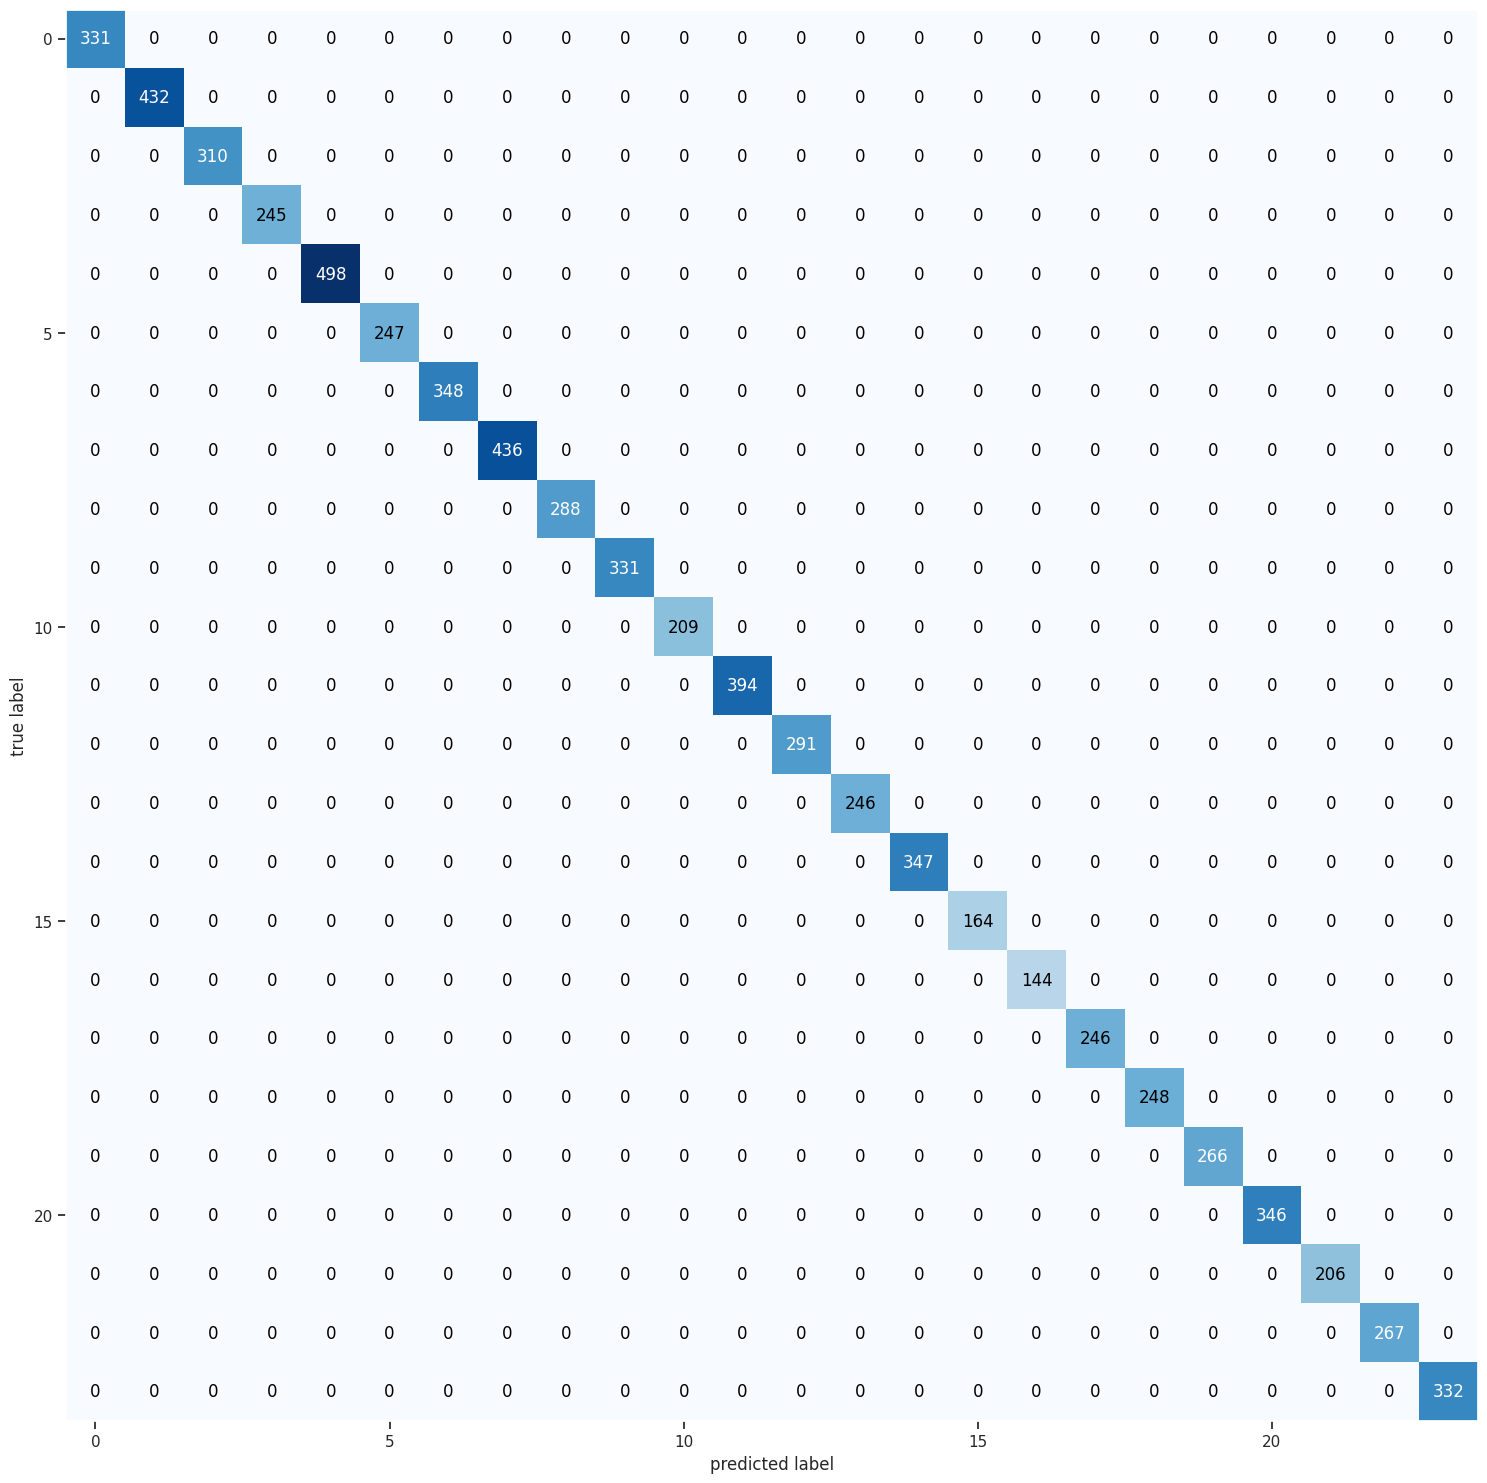

In [60]:
from sklearn.metrics import confusion_matrix # Sklearn for making confusion matrix.
from mlxtend.plotting import plot_confusion_matrix # Mlxtend for plotting confusion matrix.
cf=confusion_matrix(predictions,test_labels_string)
fig, ax = plot_confusion_matrix(conf_mat=cf)
fig.set_size_inches(15, 15) # Size of image.
plt.tight_layout() # Wide space for image.
plt.show()

<hr>

# Testing<a class="anchor" id="testing"></a>

Predicted: C 
Label: C


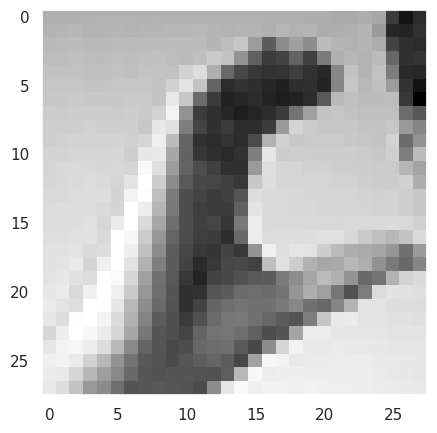

In [92]:
from numpy import random
n = int(random.randint(1,25))
plt.imshow(test_images[n].reshape(28,28),cmap="gray") # Showing images
plt.grid(False) # Removing grid for each image.
print("Predicted:",predictions[n],"\nLabel:",test_labels_string[n]) # Prediction - True Answer